In [13]:
import setup
import numpy as np
import pandas as pd
from thalpy.constants import paths
from matplotlib import pyplot as plt
from thalpy.analysis import masks, pc, plotting, feature_extraction, fc
from thalpy import base
import nibabel as nib
import seaborn as sns
import os

masker = masks.get_binary_masker(masks.MOREL_PATH)

In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogrammasks

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hier_cluster(task_matrix, n_clusters=None):
    if n_clusters is None:
        distance_threshold = 0
    else:
        distance_threshold = None
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    cluster = model.fit(np.mean(task_matrix, axis=2).swapaxes(0, 1))
    if distance_threshold is not None:
        plot_dendrogram(model)
    return cluster



In [15]:
### PCA 
from pca import pca
from scipy import stats
from scipy.spatial import distance
from IPython.display import display, HTML

def run_pca(matrix, dir_tree, output_name, task_list):
    os.chdir(MDTB_DIR_TREE.analysis_dir)
    # feature_extraction.compute_PCA(np.mean(zscored_mdtb_conditions, axis=2), masker=masker, output_name='pca_mdtb_conditions', var_list=CONDITIONS_LIST)
    pca_comps, loadings, correlated_loadings = feature_extraction.compute_PCA(matrix, output_name=output_name, var_list=task_list)
    
    # for MDTB 
    # pca_comps[:, 1] = pca_comps[:, 1] * -1
    # loadings[:, 1] = loadings[:, 1] * -1
    # correlated_loadings[1] = correlated_loadings[1] * -1

    loadings_df = pd.DataFrame(loadings, index=task_list)
    summary_df = loadings_df.describe()
    var_df = loadings_df.var(axis=0).rename("var")
    summary_df = summary_df.append(var_df)
    display(HTML(summary_df.to_html()))
    
    return pca_comps, loadings

def all_comps_task_space(pca_comps, loadings, dir_tree, task_list):
    os.chdir(dir_tree.analysis_dir)
    all_comps_task_space = np.empty([len(task_list), pca_comps.shape[0], 3])
    for i in range(3):

        # save PCs back into nifti image and visualize
        comp_array = pca_comps[:, i]
        img = masker.inverse_transform(comp_array)
    #     nib.save(img, f"pca_mdtb_pc{index}.nii")
        plotting.plot_thal(img)
        print(pca_comps.shape)

        # save each pc in task space
        pc_task_space = np.dot(np.swapaxes(loadings.T, 0, 1)[:, i, np.newaxis], np.swapaxes(pca_comps, 0,1)[np.newaxis, i, :])
        #     pc_task_space_imgs = masker.inverse_transform(pc_task_space)
        # nib.save(pc_task_space_imgs, f"pca_task_space_pc{i}.nii")
        print(pc_task_space.shape)
        print(all_comps_task_space.shape)
        all_comps_task_space[:, :, i] = pc_task_space

    #     for task in range(len(TASK_LIST)):
    #         img = masker.inverse_transform(pc_task_space[task, :])
    #         plotting.plot_thal(img)
    #         plt.show()
    
    return all_comps_task_space
    


In [16]:
from sklearn.cluster import KMeans
VOXELS = 2227

def cluster_sub(sub_matrix, k):
    sub_correlation_matrix = np.corrcoef(sub_matrix)
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(sub_correlation_matrix)

    # plus 1 is just for plotting purposes, labels with 0 show up not having color
    return model.labels_ + 1, model

def consensus_cluster(task_matrix, masker, output_dir, label=""):
    # consensus clustering

    for k_cluster in range(2, 8):
        consensus_matrix = np.empty([VOXELS, VOXELS, task_matrix.shape[-1]])
        for i in range(task_matrix.shape[-1]):
            sub_cluster, model = cluster_sub(task_matrix[:, :, i], k_cluster)
            coassignment_matrix = np.empty([VOXELS, VOXELS])
            for j in range(VOXELS):
                for k in range(VOXELS):
                    if sub_cluster[j] == sub_cluster[k]:
                        coassignment_matrix[j][k] = 1
                    else:
                        coassignment_matrix[j][k] = 0
            consensus_matrix[:, :, i] = coassignment_matrix

        mean_matrix = consensus_matrix.mean(2)
        final_consensus_cluster, model = cluster_sub(mean_matrix, k_cluster)
        final_consensus_cluster = masker.inverse_transform(final_consensus_cluster)
        nib.save(final_consensus_cluster, output_dir + f"consensus_cluter_{label}_{k_cluster}.nii")
        plotting.plot_thal(final_consensus_cluster)

def plot_clusters(sub_matrix):
    ks = range(2, 10)
    inertias = []
    for k in ks:
        cluster_atlas, model = cluster_sub(sub_matrix, k)
        plotting.plot_roi(cluster_atlas, cmap=plt.cm.get_cmap("tab10"))
        plotting.show()

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, "-o", color="black")
    plt.xlabel("number of clusters, k")
    plt.ylabel("inertia")
    plt.xticks(ks)
    plt.show()

In [17]:
# task_matrix, tstat_task_matrix, masker = setup.setup_mdtb('block', is_setup_block=True)
# zscored_task_matrix = setup.zscore_subject_2d(task_matrix)
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy', zscored_task_matrix)

MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
MDTB_DIR_TREE = base.DirectoryTree(MDTB_DIR)
MDTB_ANALYSIS_DIR = MDTB_DIR + 'analysis/'
stim_config_df = pd.read_csv(MDTB_DIR + paths.DECONVOLVE_DIR + paths.STIM_CONFIG)
CONDITIONS_LIST = stim_config_df["Stim Label"].tolist()

TASK_LIST = list(set(stim_config_df["Group"].to_list()))
TASK_LIST.remove("Rest")

# conditions_matrix, tstat_conditions_matrix, masker = setup.setup_mdtb('_norest', is_setup_block=False)
# zscored_mdtb_matrix = setup.zscore_subject_2d(conditions_matrix)
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy', zscored_mdtb_matrix)

# schaefer_mask = masks.get_roi_masker(masks.SCHAEFER_YEO7_PATH)
# cort_beta_matrix, tstat_matrix, masker = setup_blocked(
#     subjects, numsub, schaefer_mask, std_affine, "block", 400
# )
# zscored_cort_matrix = zscore_subject_2d(cort_beta_matrix)
# np.save(dir_tree.analysis_dir + "beta_cortical.npy", zscored_cort_matrix)

zscored_mdtb_task = np.load(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy')
zscored_mdtb_conditions = np.load(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy')


# FC MDTB
# cortical_masker = masks.get_roi_masker(masks.SCHAEFER_YEO7_PATH)
# fc_data = fc.FcData(MDTB_DIR, masker, cortical_masker, 'fc_thal_schaef', sessions=['ses-rest'], cores=16)
# fc_data.calc_fc()

0: MentalRotation
1: TheoryOfMind
2: Language
3: NatureMovie
4: IAPSemotion
5: ResponseAlternativesMotor
6: MotorImagery
7: Rules
8: WordPrediction
9: AnimatedMovie
10: ObjectNBackTask
11: Interval
12: VisualSearch
13: BiologicalMotion
14: Motor
15: Verbal2Back
16: ActionObservation
17: LandscapeMovie
18: ObjectViewing
19: IAPSaffective
20: Go/NoGo
21: SpatialMap
22: SpatialImagery
23: Math
24: Stroop
k: 0  group: ['MotorImagery', 'Rules', 'ObjectNBackTask', 'VisualSearch', 'Go/NoGo', 'SpatialImagery', 'Stroop']
k: 1  group: ['ResponseAlternativesMotor', 'WordPrediction', 'Motor', 'IAPSaffective', 'SpatialMap', 'Math']
k: 2  group: ['TheoryOfMind', 'Language', 'NatureMovie', 'Interval', 'ActionObservation', 'LandscapeMovie']
k: 3  group: ['IAPSemotion', 'AnimatedMovie', 'Verbal2Back']
k: 4  group: ['ObjectViewing']
k: 5  group: ['MentalRotation', 'BiologicalMotion']


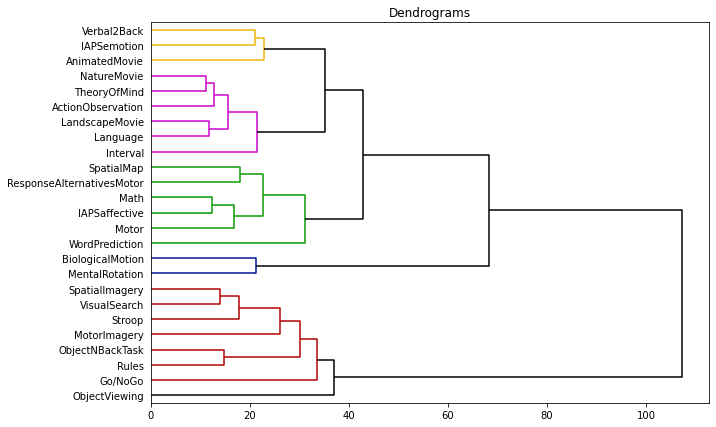

In [18]:
from thalpy.constants import paths

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['#b30000','#001299', '#089900', '#cc00c9', '#edb705']) 
dend = shc.dendrogram(shc.linkage(np.swapaxes(np.mean(zscored_mdtb_task, axis=2), 0, 1), method='ward'), color_threshold=35, above_threshold_color='black', orientation="right", labels=TASK_LIST)

conditions_cluster = hier_cluster(zscored_mdtb_task, n_clusters=6)

# dendrogram(conditions_cluster)
for i, item in enumerate(TASK_LIST):
    print(f"{i}: {item}")

for k in np.arange(len(np.unique(conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(TASK_LIST) if k == conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')

/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


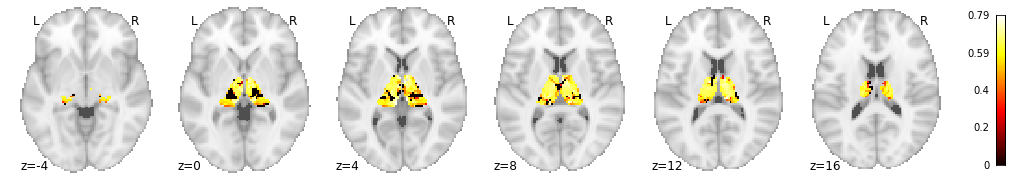

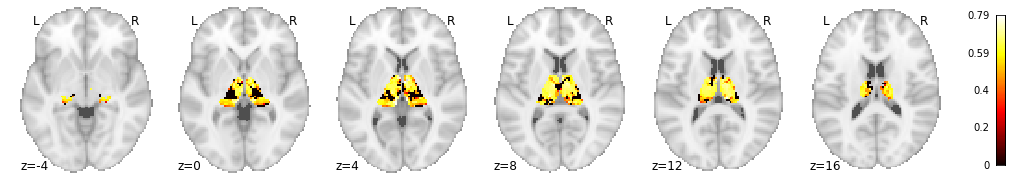

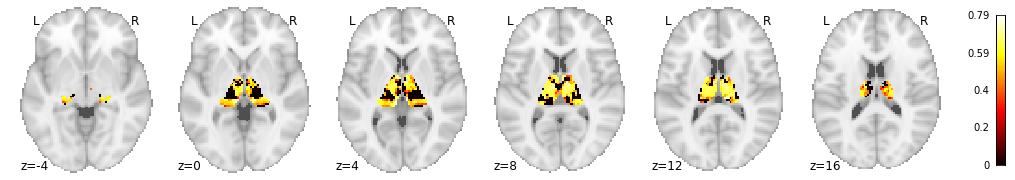

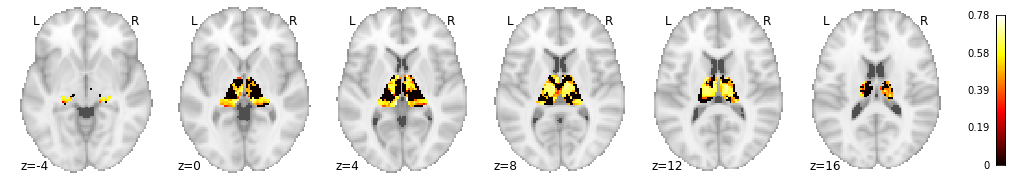

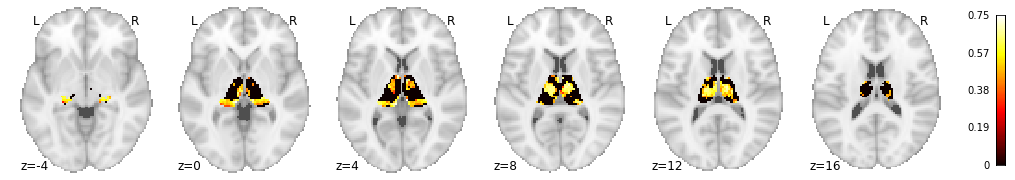

In [19]:
thresholds = [70, 75, 80, 85, 90]
pc_matrix = pc.pc_subject(np.mean(zscored_mdtb_task, axis=2), conditions_cluster.labels_, thresholds=thresholds)
pc_matrix = np.where(np.isnan(pc_matrix), 0.001, pc_matrix)
pc_matrix = np.where(pc_matrix <= 0, 0.001, pc_matrix)

for i, threshold in enumerate(thresholds):
    masker.fit()
    pc_img = masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)
    nib.save(pc_img, MDTB_DIR_TREE.analysis_dir + f"pc_{threshold}.nii")

Explained variance:
[0.49422765 0.22373263 0.07304692 0.05084266 0.03473523 0.02276043
 0.01554752 0.01323701 0.01273611 0.00932534]


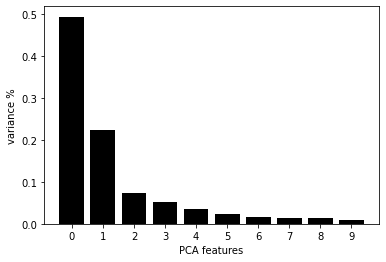

,0,1,2,3,4,5,6,7,8,9
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.043460,-0.148288,-0.038379,0.057811,-0.082280,-0.020710,0.014294,0.028996,0.010226,-0.035597
std,0.199247,0.136972,0.200331,0.195411,0.186050,0.203027,0.203602,0.201967,0.203857,0.200865
min,-0.238421,-0.333790,-0.479413,-0.278391,-0.419690,-0.523522,-0.345666,-0.411411,-0.278040,-0.383603
25%,-0.105403,-0.278436,-0.120155,-0.102838,-0.146336,-0.178192,-0.128566,-0.068609,-0.121081,-0.158278
50%,-0.038851,-0.164243,-0.066373,0.049715,-0.056964,0.026121,-0.015850,0.018834,-0.032561,-0.000543
75%,0.197091,-0.078146,0.104386,0.194231,0.038935,0.118967,0.123975,0.147885,0.113443,0.055671
max,0.446341,0.180565,0.431605,0.419871,0.367792,0.346613,0.420896,0.439419,0.466773,0.507923
var,0.039699,0.018761,0.040132,0.038185,0.034615,0.041220,0.041454,0.040791,0.041558,0.040347


(2227, 10)
(25, 2227)
(25, 2227, 3)
(2227, 10)
(25, 2227)
(25, 2227, 3)
(2227, 10)
(25, 2227)
(25, 2227, 3)


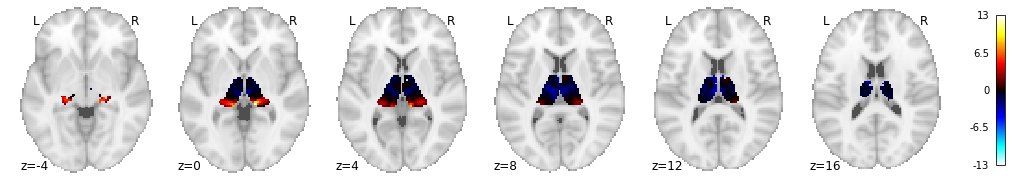

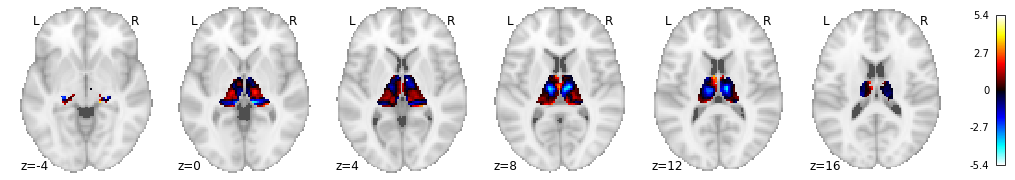

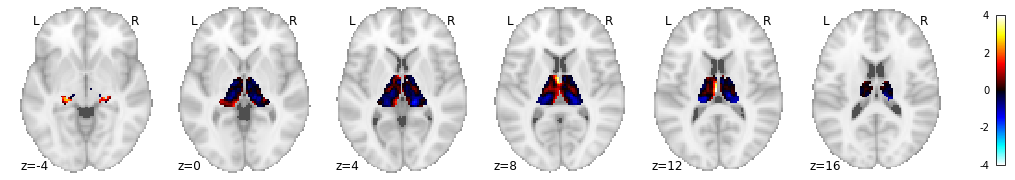

In [20]:

from pca import pca
from scipy import stats
from scipy.spatial import distance
from IPython.display import display, HTML

mdtb_pca_comps, loadings = run_pca(np.mean(zscored_mdtb_task, axis=2), MDTB_DIR_TREE, 'mdtb_pca', TASK_LIST)

mdtb_all_comps_task_space = all_comps_task_space(mdtb_pca_comps, loadings, MDTB_DIR_TREE, TASK_LIST)

In [22]:
### PCA comps correlation to PC

pc_rs = nib.load('/data/backed_up/shared/ROIs/PC.4floor.nii.gz')
masker.fit()
pc_masked = masker.transform(pc_rs)
for comp in np.arange(mdtb_pca_comps.shape[1]):
    f_corr = np.corrcoef(pc_matrix[:, 2], mdtb_pca_comps[:, comp])[0, 1] 
    rs_corr = np.corrcoef(pc_masked, mdtb_pca_comps[:, comp])[0, 1]
    print(comp)
    print(f_corr)
    print(rs_corr)

0
0.028983787290785653
-0.24927078652120105
1
-0.6278720540453105
-0.2509827498439394
2
0.23432838752285265
0.13803636456458884
3
0.03822321401467135
0.30951301762932326
4
-0.0003100018537859049
0.13363610407529544
5
-0.11491141512279458
0.02275031808447228
6
0.03914571859067229
0.09454817515961103
7
0.04931580544077717
-0.11839670903500302
8
0.06107747810732921
-0.05895473898721385
9
0.03251404255420575
0.0398178875185719


25


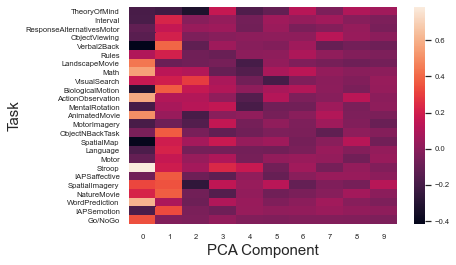

In [23]:
### Loadings Heatmap

import seaborn as sns 

df = pd.read_csv('/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/analysis/pca_mdtb_task_correlated_loadings.csv').set_index('Task')
print(len(df.index))
df["1"] = df["1"] * -1
sns.set(font_scale=0.7)
ax = sns.heatmap(df, xticklabels=True, yticklabels=True,)
plt.xlabel('PCA Component', fontsize=15)
plt.ylabel('Task', fontsize=15)

plt.savefig(MDTB_ANALYSIS_DIR + 'pca_heatmap.png', transparent=True)
plt.show()

In [83]:
### Predicted Corticals Analysis

rs = fc.load(MDTB_ANALYSIS_DIR + "fc_task_residuals.p")
NUM_RS_SUB = len([x for x in rs.fc_subjects if x is not None])
cortical_betas = np.load(MDTB_ANALYSIS_DIR + "beta_cortical.npy")
subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

# Indiviuals
# rs_data doesn't match up -- not all subjects have rs data.
def corr_sub(rs, thal_betas, cortical_betas, task_list):
    sub_cor_array = np.zeros([len(task_list), thal_betas.shape[2]]) 
    
    array_index = 0 
    for rs_index in range(len(rs.fc_subjects)):
        fc_subject = rs.fc_subjects[rs_index]
        if fc_subject is None:
            continue
        try:
            beta_index = subjects.to_subargs_list().index(fc_subject.name)
        except:
            continue
        
        sub_rs = rs.fc_subjects[rs_index].seed_to_voxel_correlations[:, :]
        predicted_corticals = np.dot(np.swapaxes(thal_betas[:, :, beta_index], 0, 1), sub_rs)
        sub_cortical_betas = np.swapaxes(cortical_betas[:, :, beta_index], 0, 1)
        for i, task in enumerate(task_list):
            corr = np.corrcoef(predicted_corticals[i, :], sub_cortical_betas[i, :])[0, 1]
            sub_cor_array[i, array_index] = corr
            
            
        array_index += 1
    
    return sub_cor_array

sub_cor_array = corr_sub(rs, zscored_mdtb_task, cortical_betas, TASK_LIST)


# Averaged across subjects
def corr_avg(rs, thal_betas, cortical_betas, task_list):
    avg_predicted_corticals = np.dot(np.swapaxes(thal_betas, 0, 1), np.mean(rs.data, axis=2))
    avg_cortical_betas = np.swapaxes(np.mean(cortical_betas, axis=2), 0, 1)
    cor_array = np.empty([len(task_list)])
    for i, task in enumerate(task_list):
        cor = np.corrcoef(avg_predicted_corticals[i, :], avg_cortical_betas[i, :])[0, 1]
        cor_array[i] = cor

    return cor_array

avg_cor_array = corr_avg(rs, np.mean(zscored_mdtb_task, axis=2), cortical_betas, TASK_LIST)

# Null Models
def null_corr(k, thal_betas, cortical_betas, rs, task_list):
    null_corr_array = np.empty([k, len(task_list)])
    null_sub_corr_array = np.empty([k, len(task_list), thal_betas.shape[2]])
    for i in np.arange(k):
        rand_avg_thal = np.mean(thal_betas, axis=2)
        rand_sub_thal = np.copy(thal_betas)
        for j in np.arange(len(task_list)):
            rand_avg_thal[:, j] = np.random.permutation(rand_avg_thal[:, j])
            for k in np.arange(thal_betas.shape[2]):
                rand_sub_thal[:, j, k] = np.random.permutation(rand_sub_thal[:, j, k])
        null_corr_array[i, :] = corr_avg(rs, rand_avg_thal, cortical_betas, task_list)
        null_sub_corr_array[i, :, :] = corr_sub(rs, rand_sub_thal, cortical_betas, task_list)
    
    return null_corr_array, null_sub_corr_array

# null 
null_corr_array, null_sub_corr_array = null_corr(1, zscored_mdtb_task, cortical_betas, rs, TASK_LIST)

# evoked response to 1
sub_evoked_1 = corr_sub(rs, np.ones(zscored_mdtb_task.shape), cortical_betas, TASK_LIST)
avg_evoked_1 = corr_avg(rs, np.ones([zscored_mdtb_task.shape[0], zscored_mdtb_task.shape[1]]), cortical_betas, TASK_LIST)

# threshold high pca voxels
comps_task_space_corr = np.zeros([len(TASK_LIST), 3])
for i in np.arange(3):
    comps_task_space_corr[:, i] = corr_avg(rs, np.swapaxes(mdtb_all_comps_task_space[:, :, i], 0 ,1), cortical_betas, TASK_LIST)

,MentalRotation,TheoryOfMind,Language,NatureMovie,IAPSemotion,ResponseAlternativesMotor,MotorImagery,Rules,WordPrediction,AnimatedMovie,ObjectNBackTask,Interval,VisualSearch,BiologicalMotion,Motor,Verbal2Back,ActionObservation,LandscapeMovie,ObjectViewing,IAPSaffective,Go/NoGo,SpatialMap,SpatialImagery,Math,Stroop,total
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,525.000000
mean,0.310120,0.280691,0.270095,0.338878,0.471329,0.355390,0.285762,0.510871,0.428240,0.284645,0.509649,0.403509,0.437110,0.548882,0.499184,0.287943,0.496483,0.293228,0.524281,0.570270,0.372682,0.588281,0.459412,0.456627,0.389963,0.414941
std,0.180068,0.150955,0.148596,0.220156,0.132231,0.196587,0.174477,0.146128,0.163928,0.108663,0.147176,0.187673,0.127731,0.153746,0.118530,0.256450,0.164823,0.158505,0.127303,0.142299,0.141993,0.180548,0.143998,0.159819,0.176395,0.188449
min,0.023238,0.027519,0.026145,-0.133079,0.207025,0.044708,0.013396,0.140129,0.090279,0.027847,0.242511,0.092261,0.119021,0.297881,0.264980,-0.229694,0.204487,0.070854,0.266023,0.371899,0.085407,0.113290,0.228334,0.140773,0.019768,-0.229694
25%,0.187223,0.165193,0.177460,0.209793,0.381526,0.233659,0.191141,0.405619,0.332223,0.222403,0.377455,0.255808,0.389238,0.387254,0.411713,0.094195,0.401024,0.182471,0.515960,0.439094,0.271900,0.505009,0.301829,0.367900,0.273234,0.283743
50%,0.285741,0.291623,0.271759,0.311693,0.513288,0.316152,0.309672,0.553359,0.388586,0.289256,0.533714,0.406598,0.429254,0.562305,0.514338,0.333033,0.480998,0.242101,0.552114,0.539260,0.327223,0.648093,0.477898,0.446983,0.348797,0.411713
75%,0.415599,0.383372,0.348834,0.544068,0.550423,0.464958,0.393483,0.610231,0.595030,0.354393,0.627736,0.578147,0.499236,0.647886,0.592812,0.475723,0.588219,0.404342,0.584282,0.718499,0.486957,0.730545,0.588619,0.563108,0.537233,0.564388
max,0.682073,0.659271,0.556823,0.673470,0.645688,0.720928,0.595164,0.735908,0.697935,0.491661,0.688970,0.723814,0.671797,0.807440,0.675206,0.625387,0.785540,0.669546,0.704095,0.795820,0.623449,0.796725,0.634598,0.798455,0.710415,0.807440


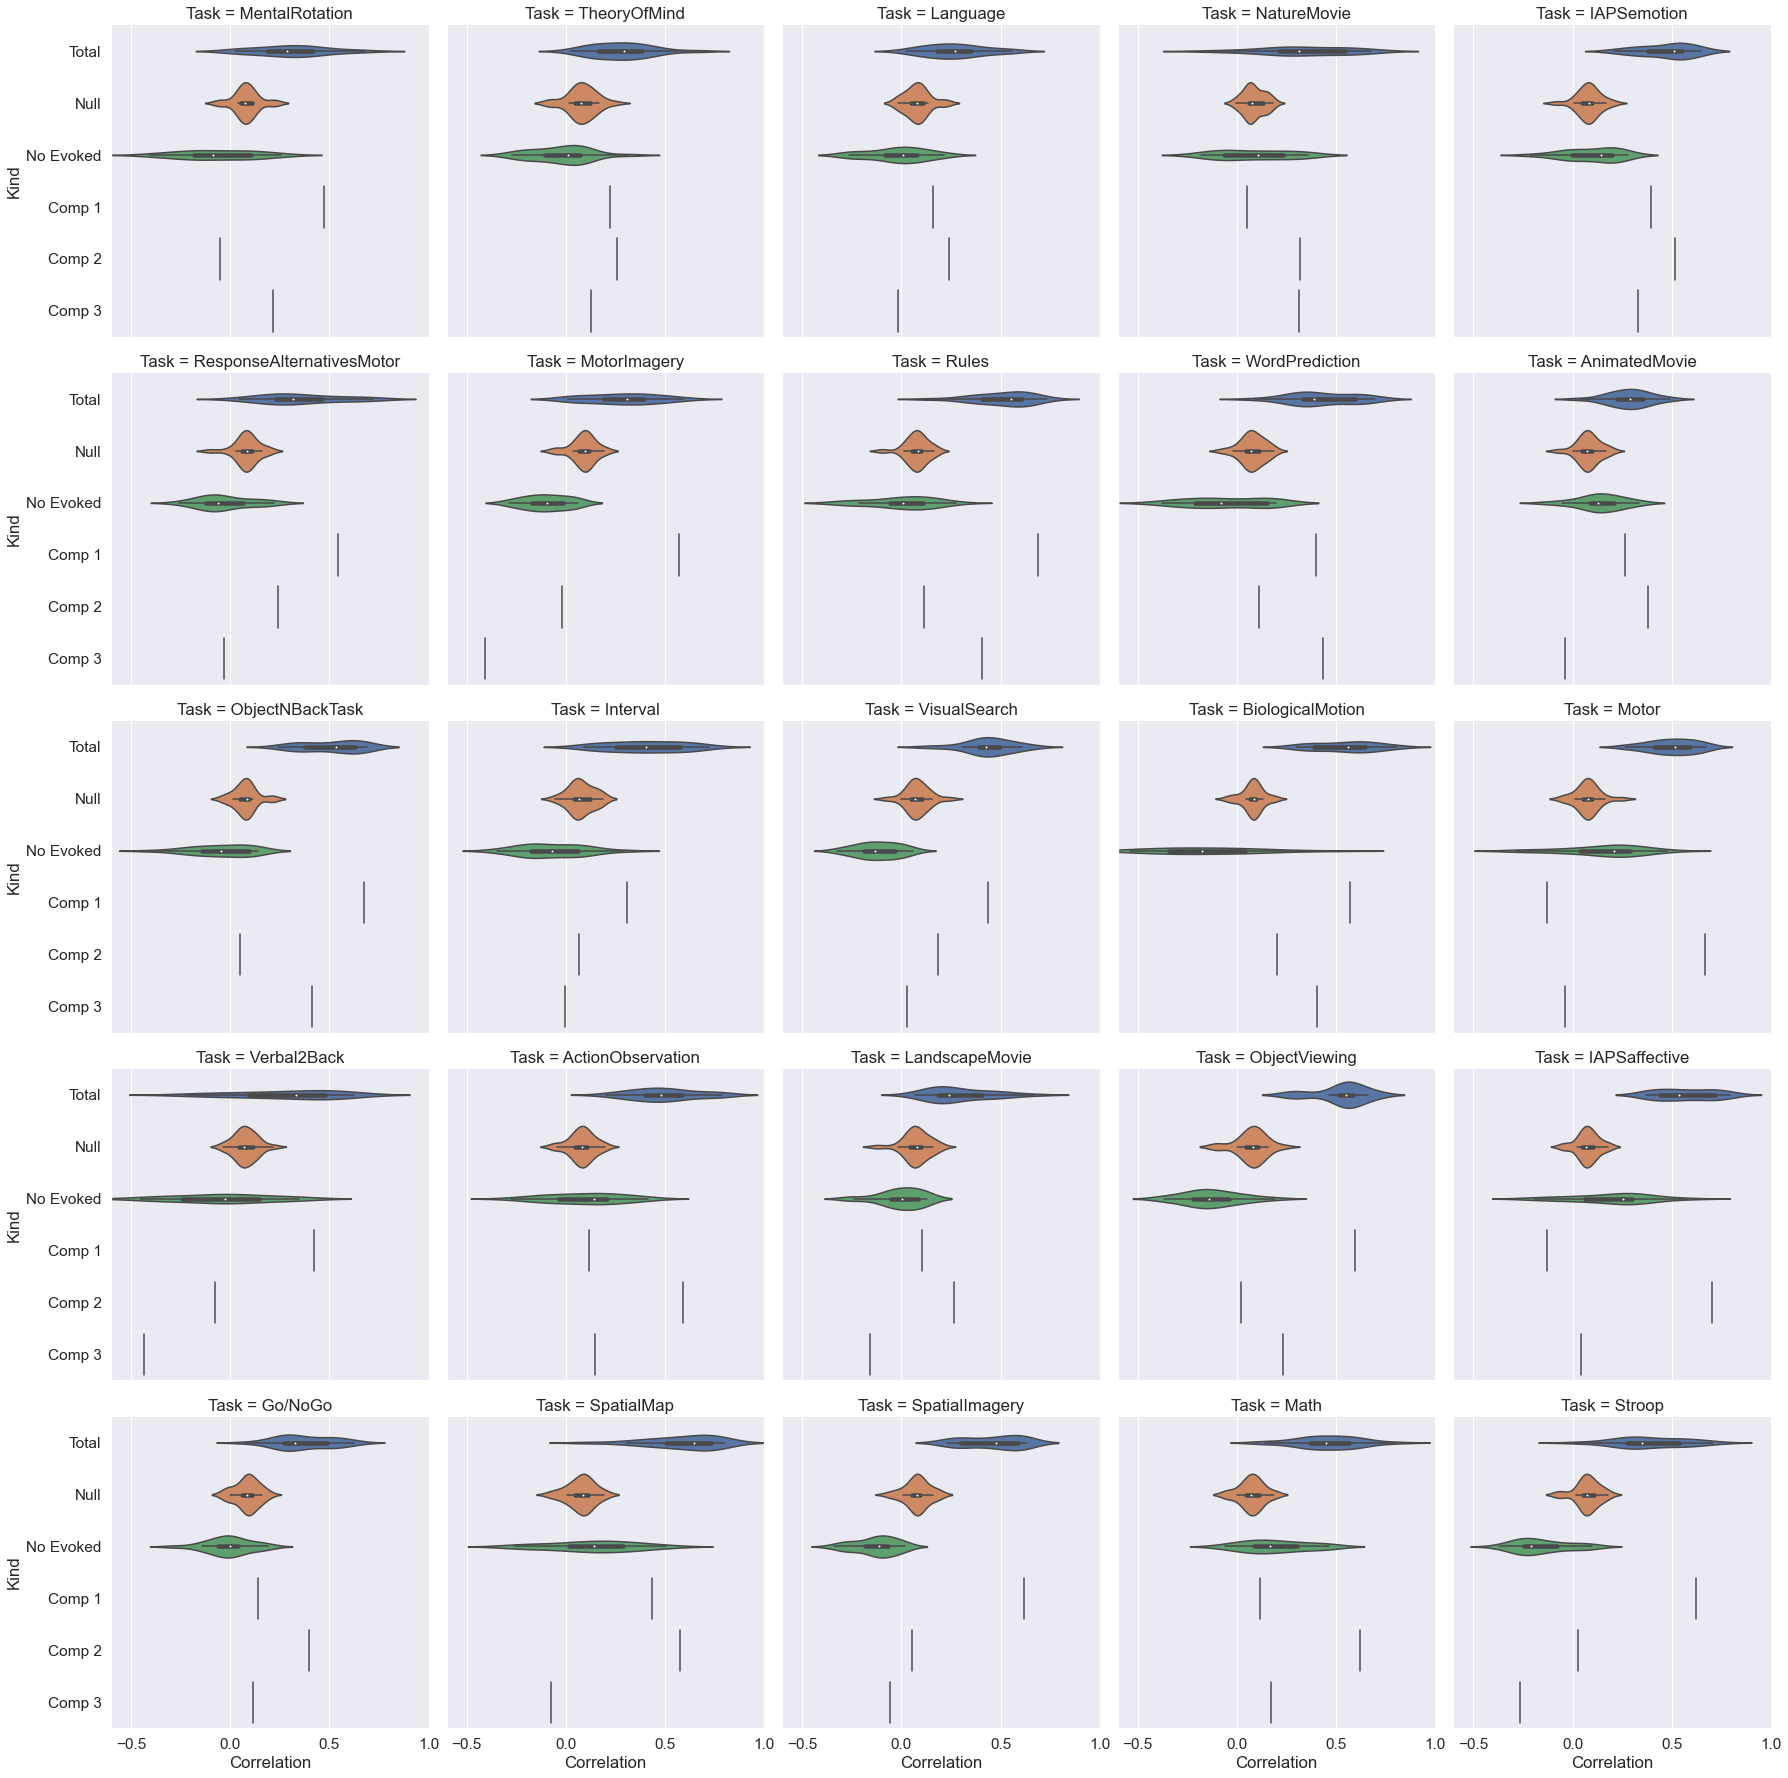

In [25]:
# subject correlations
master_df = pd.DataFrame(columns=['Subject', 'Task', 'Kind', 'Correlation'])
for i in range(len(TASK_LIST)):
    for j in range(sub_cor_array.shape[1]):
        master_df = master_df.append(pd.DataFrame([[j, TASK_LIST[i], 'Total', sub_cor_array[i, j]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
        master_df = master_df.append(pd.DataFrame([[ j, TASK_LIST[i], 'Null', np.mean(null_sub_corr_array[i, j])]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
        master_df = master_df.append(pd.DataFrame([[ j, TASK_LIST[i], 'No Evoked', sub_evoked_1[i, j]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TASK_LIST[i], 'Comp 1', comps_task_space_corr[i, 0]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TASK_LIST[i], 'Comp 2', comps_task_space_corr[i, 1]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TASK_LIST[i], 'Comp 3', comps_task_space_corr[i, 2]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))

sns.set(font_scale=1.4)
fig = sns.catplot(kind='violin', orient="h", data=master_df, x='Correlation', y='Kind', col="Task", col_wrap=5)
plt.xlim([-0.6, 1])
plt.xticks([-0.5, 0, .50, 1])

sub_corr_df = pd.DataFrame(np.swapaxes(sub_cor_array, 0, 1), columns=TASK_LIST)
sub_corr_stats = sub_corr_df.describe()
total_sub_corr_df = pd.DataFrame(sub_cor_array.flatten())
sub_corr_stats['total'] = total_sub_corr_df.describe()
display(HTML(sub_corr_stats.to_html()))


In [65]:
from thalpy.analysis import glm, masks
from thalpy import base

tomoya_dir_tree = base.DirectoryTree('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya')
subjects = base.get_subjects(tomoya_dir_tree.deconvolve_dir, tomoya_dir_tree)
stim_config_df = pd.read_csv(tomoya_dir_tree.deconvolve_dir + paths.STIM_CONFIG)
TOMOYA_TASKS = stim_config_df["Stim Label"].tolist()
masker = masks.get_binary_masker(masks.MOREL_PATH)

masker.fit(nib.load('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya/3dDeconvolve/sub-01/FIRmodel_MNI_stats.nii'))
# tomoya_beta_matrix = glm.load_brik(subjects, masker, 'FIRmodel_MNI_stats.nii', 2227, TOMOYA_TASKS)
# np.save('tomoya_beta.npy', tomoya_beta_matrix)

schaefer_mask = masks.get_roi_masker(masks.SCHAEFER_YEO7_PATH)
schaefer_mask.fit(nib.load('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya/3dDeconvolve/sub-01/FIRmodel_MNI_stats.nii'))
# tomoya_cortical_betas = glm.load_brik(subjects, schaefer_mask, "FIRmodel_MNI_stats.nii", 400, TOMOYA_TASKS)
# np.save(tomoya_dir_tree.analysis_dir + "beta_corticals.npy", tomoya_cortical_betas)

# fc_data = fc.FcData(
#     tomoya_dir_tree.dataset_dir,
#     masker,
#     schaefer_mask,
#     "fc_task_residuals",
#     subjects=subjects,
#     censor=False,
#     is_denoise=False,
#     bold_dir=tomoya_dir_tree.deconvolve_dir,
#     bold_WC="*FIRmodel_errts.nii.gz",
#     cores=8,
# )
# fc_data.calc_fc()
tomoya_rs = fc.load(tomoya_dir_tree.analysis_dir + "fc_task_residuals.p")

tomoya_beta_matrix = np.load(os.path.join(tomoya_dir_tree.analysis_dir, 'tomoya_beta.npy'))
tomoya_cortical_betas = np.load(os.path.join(tomoya_dir_tree.analysis_dir, 'beta_corticals.npy'))

Explained variance:
[0.24283326 0.13583435 0.1266729  0.04636843 0.03969473 0.03290696
 0.02337343 0.02231827 0.0147305  0.01280407 0.01019627 0.0096635
 0.00871992 0.0083116  0.00783355 0.00729664 0.00707801 0.00694758
 0.0066828  0.00632861 0.00603776 0.00576743 0.00572225 0.00564436
 0.0055566  0.00528144 0.00519032 0.00510793 0.00487782 0.00473018
 0.00469584 0.00440235 0.00427931 0.00420174 0.00414602 0.0041043
 0.00400172 0.00395875 0.00373227 0.00360605 0.00346723 0.00344158
 0.00338352 0.00328806 0.00326343 0.00323437 0.0031758  0.00314896
 0.0030706  0.00296629 0.00295462 0.00283488 0.00280826 0.00271394
 0.00265728 0.00261975 0.00252554 0.00248447 0.00245441 0.00241614
 0.00236296 0.00231401 0.0022496  0.00224168 0.00219873 0.00215903
 0.00212172 0.00210136 0.00206439]


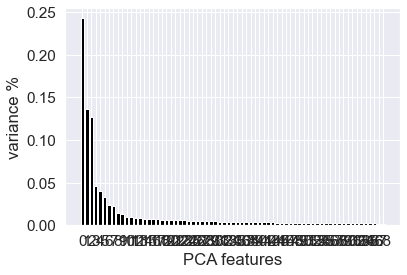

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,-0.085571,0.036732,0.022127,-0.009790,-0.008405,0.000809,-0.001752,0.003075,-0.005893,0.001262,0.002234,0.002889,0.001162,0.001384,0.001087,-0.000471,0.001047,0.005046,0.001024,0.005282,-0.002884,0.000859,-0.002475,0.000732,-0.000668,0.000564,0.003293,-0.000279,-0.000662,0.000222,-0.001109,-0.000223,-0.002917,-0.000806,0.002484,-0.000385,-0.001176,-0.000318,-0.000100,0.000778,-0.001072,0.000293,-0.003170,-0.001160,-0.002414,0.001467,-0.000023,-0.000699,-0.001702,0.001542,0.000017,0.000116,0.000720,0.002116,-0.000280,-0.000049,0.001346,-0.000482,-0.000305,0.000835,0.001914,-0.000941,-0.000298,0.001082,-0.001326,-0.000469,-0.000270,0.000106,-0.002322
std,0.048118,0.091359,0.095992,0.098041,0.098170,0.098530,0.098517,0.098484,0.098355,0.098525,0.098507,0.098490,0.098526,0.098523,0.098527,0.098532,0.098527,0.098402,0.098528,0.098390,0.098490,0.098529,0.098502,0.098530,0.098531,0.098531,0.098477,0.098533,0.098531,0.098533,0.098527,0.098533,0.098489,0.098530,0.098501,0.098532,0.098526,0.098532,0.098533,0.098530,0.098527,0.098532,0.098481,0.098526,0.098503,0.098522,0.098533,0.098530,0.098518,0.098521,0.098533,0.098533,0.098530,0.098510,0.098533,0.098533,0.098524,0.098532,0.098532,0.098529,0.098514,0.098528,0.098532,0.098527,0.098524,0.098532,0.098533,0.098533,0.098505
min,-0.177235,-0.152884,-0.111253,-0.224027,-0.710412,-0.567162,-0.307649,-0.270773,-0.252546,-0.273587,-0.267978,-0.365291,-0.312789,-0.281549,-0.540610,-0.276339,-0.245865,-0.257560,-0.271299,-0.207703,-0.320212,-0.342785,-0.256088,-0.289004,-0.233984,-0.244659,-0.227564,-0.252074,-0.237049,-0.177223,-0.357464,-0.318637,-0.228953,-0.371198,-0.271048,-0.315348,-0.284201,-0.321172,-0.353824,-0.284193,-0.331821,-0.281304,-0.262934,-0.395641,-0.249567,-0.348806,-0.222379,-0.262660,-0.198598,-0.240317,-0.254057,-0.311860,-0.240735,-0.268883,-0.207393,-0.213887,-0.261715,-0.276194,-0.228046,-0.252962,-0.274945,-0.195654,-0.232604,-0.213593,-0.229008,-0.268339,-0.270710,-0.192165,-0.289889
25%,-0.126953,-0.041636,-0.065940,-0.099949,-0.049056,-0.053818,-0.052972,-0.060656,-0.073990,-0.064994,-0.044098,-0.050810,-0.048835,-0.061726,-0.045997,-0.062357,-0.054881,-0.058274,-0.055864,-0.066061,-0.060854,-0.057318,-0.062521,-0.053800,-0.057159,-0.064635,-0.058498,-0.056861,-0.067423,-0.069005,-0.050156,-0.062722,-0.060977,-0.044264,-0.051096,-0.054820,-0.052999,-0.066785,-0.058634,-0.064493,-0.061974,-0.056967,-0.062146,-0.065920,-0.077555,-0.049087,-0.073045,-0.062830,-0.062392,-0.052996,-0.056446,-0.055933,-0.064702,-0.062264,-0.063043,-0.076504,-0.060495,-0.053020,-0.074335,-0.053787,-0.068645,-0.074611,-0.071806,-0.065795,-0.073434,-0.078734,-0.055992,-0.057026,-0.056145
50%,-0.083682,0.048730,0.008634,-0.007215,0.009894,-0.007259,-0.009767,0.004794,-0.009070,0.003701,0.005018,-0.003068,-0.007173,0.002572,0.000398,0.002948,-0.004394,-0.000494,-0.003972,0.001059,-0.004408,-0.004857,-0.006494,-0.000133,-0.009849,0.003789,0.001247,-0.015158,0.005769,-0.003808,-0.012664,0.006615,0.008387,0.008638,-0.003896,0.004467,0.000224,-0.004

(2227, 69)
(104, 2227)
(104, 2227, 3)
(2227, 69)
(104, 2227)
(104, 2227, 3)
(2227, 69)
(104, 2227)
(104, 2227, 3)
(104, 2227, 3)


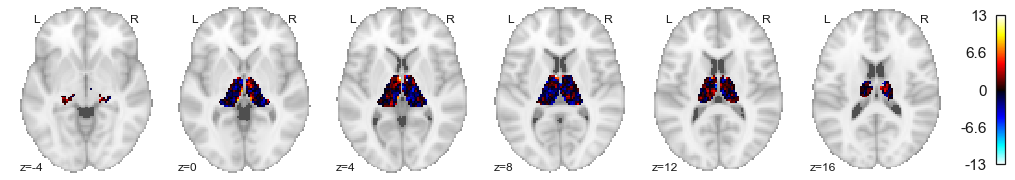

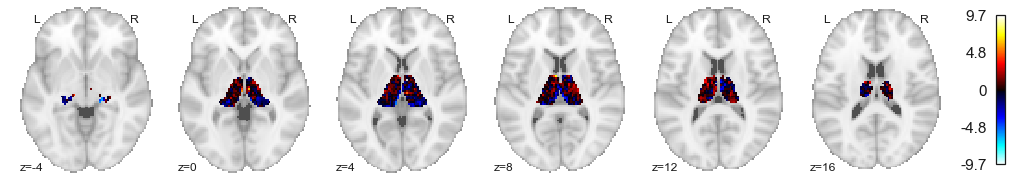

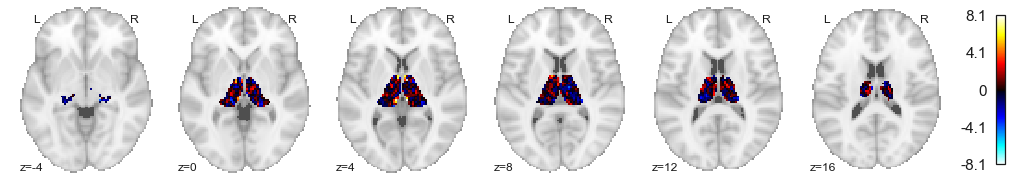

In [53]:
# PCA on Tomoya
averaged_sub_beta_tomoya = np.mean(tomoya_beta_matrix, axis=2)
tomoya_pca_comps, tomoya_loadings = run_pca(averaged_sub_beta_tomoya, tomoya_dir_tree, 'tomoya_pca', TOMOYA_TASKS)
tomoya_task_space = all_comps_task_space(tomoya_pca_comps, tomoya_loadings, tomoya_dir_tree, TOMOYA_TASKS)

/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


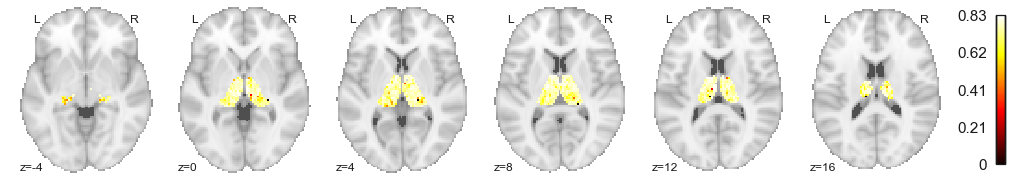

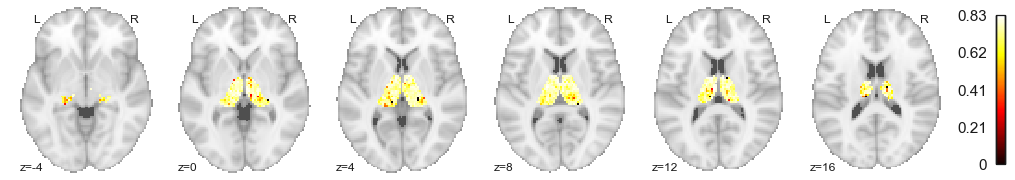

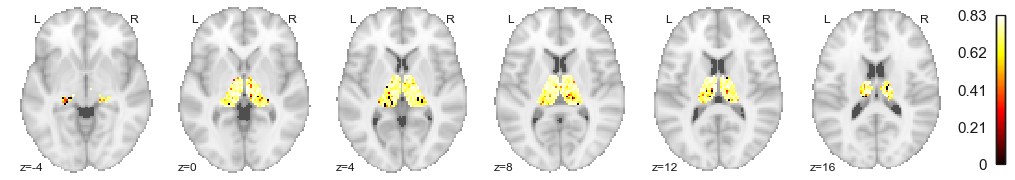

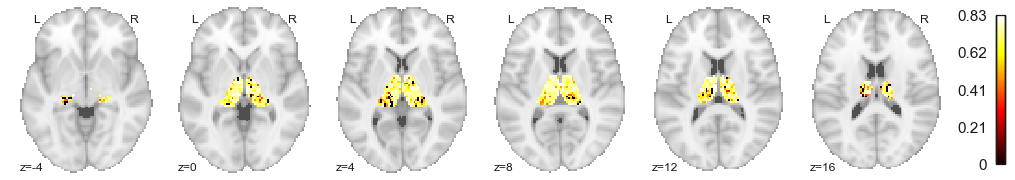

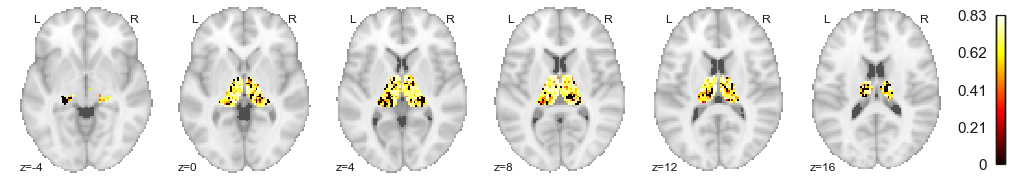

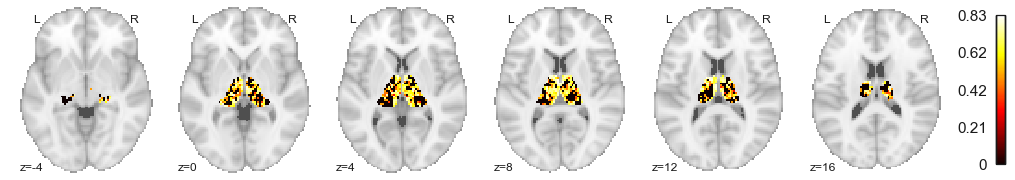

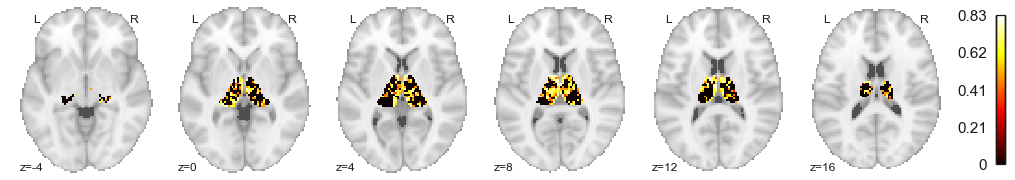

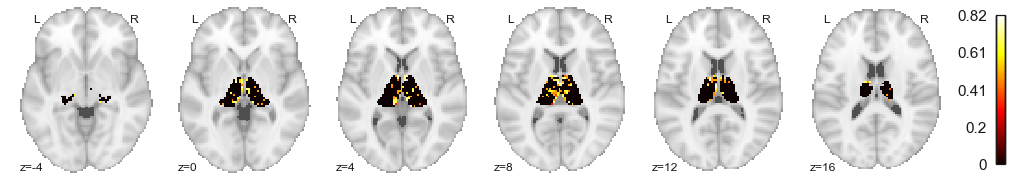

In [28]:

auditory = ["TimeMov","Rhythm","Harmony","TimeSound","CountTone","SoundRight","SoundLeft","RateDisgustSound","RateNoisy","RateBeautySound","SoundPlace","DailySound","EmotionVoice","MusicCategory","ForeignListen","LanguageSound","AnimalVoice", "FeedbackPos"]
introspection = ["LetterFluency","CategoryFluency","RecallKnowledge","ImagineMove","ImagineIf","RecallFace","ImaginePlace","RecallPast","ImagineFuture"]
motor = ["RateConfidence","RateSleepy","RateTired","EyeMoveHard","EyeMoveEasy","EyeBlink","RestClose","RestOpen","PressOrdHard","PressOrdEasy","PressLR","PressLeft","PressRight"]
memory = ["MemoryNameHard","MemoryNameEasy","MatchNameHard","MatchNameEasy","RelationLogic","CountDot","MatchLetter","MemoryLetter","MatchDigit","MemoryDigit","CalcHard","CalcEasy"]
language = ["RecallTaskHard","RecallTaskEasy","DetectColor","Recipe","TimeValue","DecidePresent","ForeignReadQ","ForeignRead","MoralImpersonal","MoralPersonal","Sarcasm","Metaphor","ForeignListenQ","WordMeaning","RatePoem", "PropLogic"]
visual = ["EmotionFace","Flag","DomesiticName","WorldName","DomesiticPlace","WorldPlace","StateMap","MapIcon","TrafficSign","MirrorImage","DailyPhoto","AnimalPhoto","RateBeautyPic","DecidePeople","ComparePeople","RateHappyPic","RateSexyPicM","DecideFood","RateDeliciousPic","RatePainfulPic","RateDisgustPic","RateSexyPicF","DecideShopping","DetectDifference","DetectTargetPic","CountryMap","Money","Clock","RateBeautyMov","DetectTargetMov","RateHappyMov","RateSexyMovF","RateSexyMovM","RateDeliciousMov","RatePainfulMov","RateDisgustMov"]
groups = [visual, language, memory, motor, introspection, auditory]

task_category = []
for task in TOMOYA_TASKS:
    for i, group in enumerate(groups):
        if task in group:
            task_category.append(i)
            continue

# PC Tomoya
thresholds = [70, 75, 80, 85, 90, 95, 97, 99]
pc_matrix = pc.pc_subject(averaged_sub_beta_tomoya, task_category, thresholds=thresholds)
pc_matrix = np.where(np.isnan(pc_matrix), 0.001, pc_matrix)
pc_matrix = np.where(pc_matrix <= 0, 0.001, pc_matrix)

for i, threshold in enumerate(thresholds):
    pc_img = masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)
    nib.save(pc_img, MDTB_DIR_TREE.analysis_dir + f"pc_{threshold}.nii")


In [84]:
## Tomoya Activity Flow

subjects = base.get_subjects(tomoya_dir_tree.deconvolve_dir, tomoya_dir_tree)

tom_avg_cor_array = corr_avg(tomoya_rs, averaged_sub_beta_tomoya, tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array = corr_sub(tomoya_rs, tomoya_beta_matrix, tomoya_cortical_betas, TOMOYA_TASKS)

# evoked response to 1
tom_sub_evoked_1 = corr_sub(tomoya_rs, np.ones(tomoya_beta_matrix.shape), tomoya_cortical_betas, TOMOYA_TASKS)
tom_avg_evoked_1 = corr_avg(tomoya_rs, np.ones([tomoya_beta_matrix.shape[0], tomoya_beta_matrix.shape[1]]), tomoya_cortical_betas, TOMOYA_TASKS)

#null
tom_null_corr_array, tom_null_sub_corr_array = null_corr(100, tomoya_beta_matrix, tomoya_beta_corticals, tomoya_rs, TOMOYA_TASKS)

# threshold high pca voxels
tom_comps_task_space_corr = np.zeros([len(TOMOYA_TASKS), 3])
for i in np.arange(3):
    tom_comps_task_space_corr[:, i] = corr_avg(tomoya_rs, np.swapaxes(tomoya_task_space[:, :, i], 0 ,1), tomoya_cortical_betas, TOMOYA_TASKS)

,Sarcasm,StateMap,ForeignListen,ForeignListenQ,EyeMoveHard,MusicCategory,FeedbackPos,PressLeft,MoralPersonal,AnimalVoice,Flag,CountDot,PropLogic,RateBeautySound,DecidePresent,TimeMov,DecidePeople,RateDisgustMov,Clock,AnimalPhoto,RateHappyPic,DailySound,EyeBlink,ImagineMove,SoundLeft,WorldPlace,Recipe,RelationLogic,DomesiticPlace,ComparePeople,DailyPhoto,SoundRight,PressRight,RateSexyPicF,RateDisgustSound,MemoryLetter,RateSexyPicM,MatchLetter,TimeSound,LetterFluency,RateDeliciousPic,RecallKnowledge,DetectTargetPic,MapIcon,ImaginePlace,MoralImpersonal,RestClose,CountryMap,ImagineIf,DecideShopping,PressOrdHard,RateBeautyPic,PressLR,LanguageSound,RateBeautyMov,ImagineFuture,RatePainfulPic,DetectTargetMov,WordMeaning,EyeMoveEasy,RatePoem,RecallFace,RecallTaskHard,CountTone,SoundPlace,DetectColor,Money,Rhythm,PressOrdEasy,RateDisgustPic,Metaphor,MirrorImage,EmotionVoice,RateConfidence,CategoryFluency,RateSleepy,RateSexyMovF,EmotionFace,RatePainfulMov,RateDeliciousMov,RateSexyMovM,ForeignRead,ForeignReadQ,CalcHard,CalcEasy,TrafficSign,RestOpen,RateTired,MemoryNameHard,MatchNameHard,DomesiticName,MemoryNameEasy,MatchNameEasy,WorldName,DetectDifference,RateNoisy,DecideFood,RecallTaskEasy,MemoryDigit,RecallPast,MatchDigit,TimeValue,RateHappyMov,Harmony,total
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,525.000000
mean,0.189812,0.212044,0.243734,0.294181,0.092778,0.305901,0.204885,0.329685,0.161920,0.103858,0.299975,0.182075,0.209069,0.222581,0.172163,0.134656,0.125289,0.248515,0.219128,0.118629,0.212697,0.123425,0.167966,0.215961,0.294641,0.206923,0.155753,0.230372,0.248720,0.082250,0.248965,0.273298,0.289495,0.189496,0.227835,0.207563,0.259113,0.137632,0.255381,0.213820,0.147607,0.175036,0.194464,0.203088,0.195969,0.132665,0.157067,0.347594,0.108596,0.179635,0.173826,0.171676,0.158440,0.299899,0.204354,0.154157,0.238118,0.121580,0.191314,0.230124,0.205446,0.292205,0.177979,0.336181,0.367996,0.208497,0.207544,0.200995,0.268374,0.275618,0.186025,0.245263,0.284168,0.233659,0.264527,0.298616,0.238341,0.171825,0.183242,0.143915,0.222797,0.213273,0.201791,0.290703,0.332399,0.234063,0.243343,0.270606,0.170514,0.328723,0.199401,0.222440,0.329421,0.123813,0.211841,0.226868,0.259934,0.211560,0.219197,0.280847,0.262083,0.146318,0.182169,0.164154,0.414941
std,0.098155,0.191785,0.115519,0.145447,0.143173,0.185610,0.088432,0.124317,0.114163,0.066526,0.133073,0.112390,0.092708,0.222506,0.266201,0.109071,0.146417,0.129245,0.138585,0.095614,0.203823,0.133180,0.260620,0.178885,0.062873,0.234396,0.122069,0.171137,0.221588,0.095786,0.167237,0.223597,0.213165,0.079131,0.176934,0.139972,0.126633,0.231714,0.109793,0.134540,0.153884,0.186345,0.171981,0.116214,0.149770,0.160028,0.100812,0.115540,0.047178,0.104773,0.046856,0.101181,0.055105,0.246263,0.127706,0.013881,0.118304,0.081538,0.112306,0.088521,0.149546,0.168025,0.131788,0.077693,0.158748,0.133825,0.068386,0.105708,0.128336,0.132601,0.167804,0.102604,0.172663,0.140290,0.084715,0.129872,0.135087,0.148077,0.212889,0.113407,0.075426,0.091001,0.210995,0.143824,0.171401,0.137849,0.112553,0.086672,0.111537,0.082977,0.286576,0.187

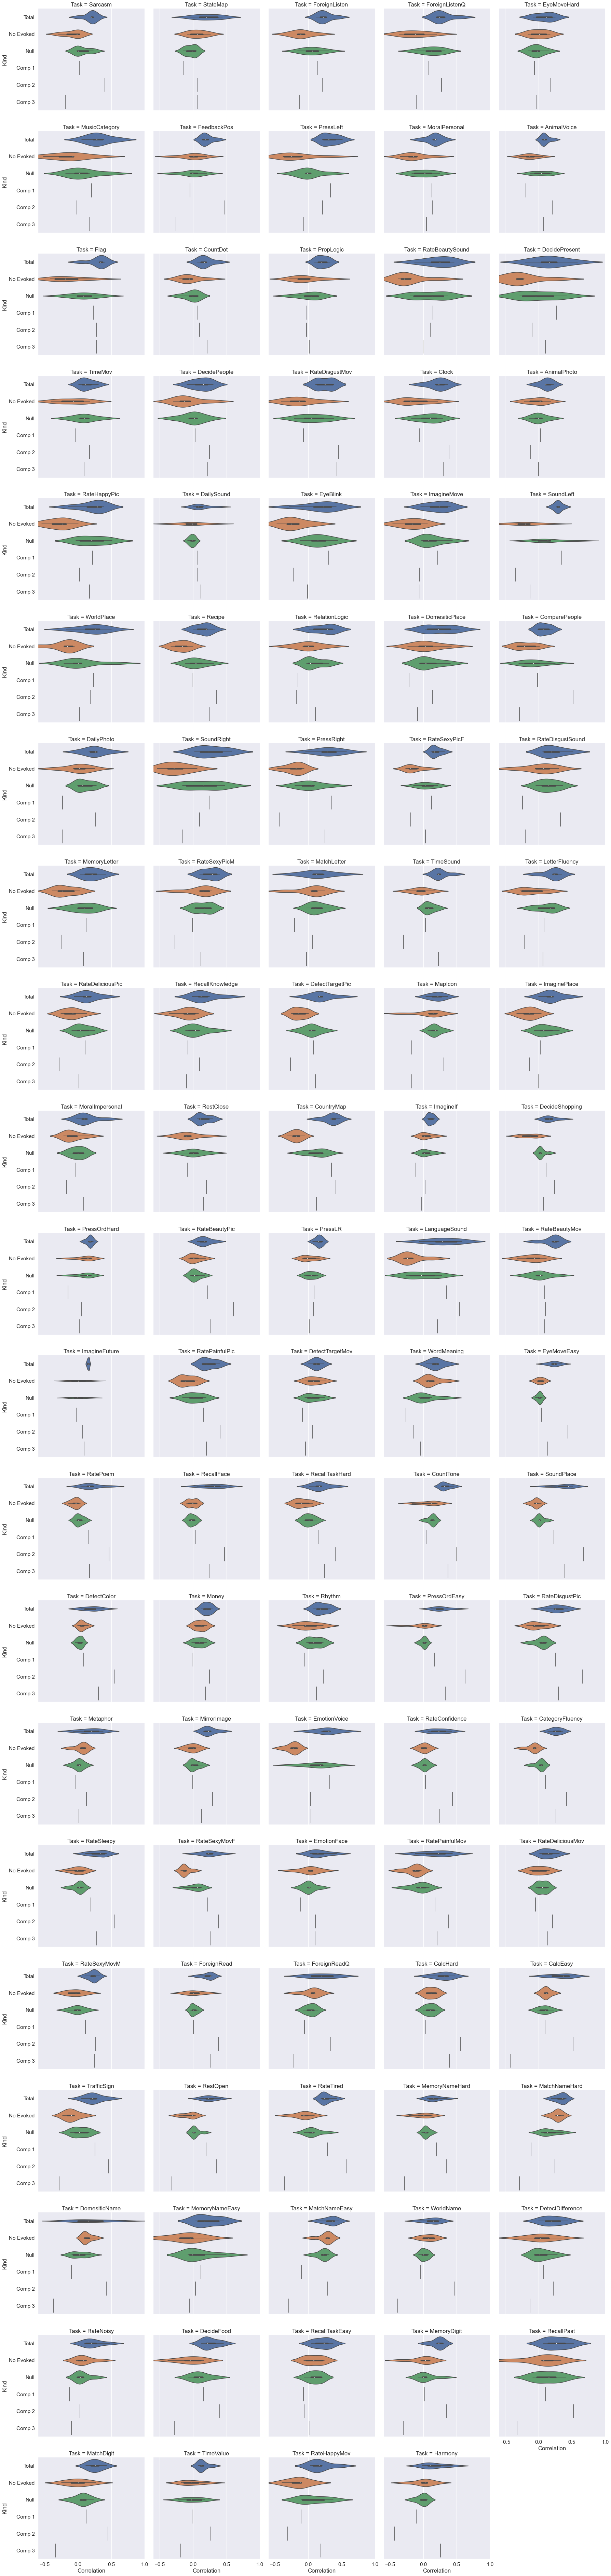

In [81]:
## Plot Activity flow

# subject correlations
master_df = pd.DataFrame(columns=['Subject', 'Task', 'Kind', 'Correlation'])
for i in range(len(TOMOYA_TASKS)):
    for j in range(tom_sub_cor_array.shape[1]):
        master_df = master_df.append(pd.DataFrame([[j, TOMOYA_TASKS[i], 'Total', tom_sub_cor_array[i, j]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
        master_df = master_df.append(pd.DataFrame([[ j, TOMOYA_TASKS[i], 'No Evoked', tom_sub_evoked_1[i, j]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
        master_df = master_df.append(pd.DataFrame([[ j, TOMOYA_TASKS[i], 'Null', np.mean(tom_null_sub_corr_array[:, i, j])]], columns=['Subject', 'Task', 'Kind', 'Correlation']))

        
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TOMOYA_TASKS[i], 'Comp 1', tom_comps_task_space_corr[i, 0]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TOMOYA_TASKS[i], 'Comp 2', tom_comps_task_space_corr[i, 1]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
    master_df = master_df.append(pd.DataFrame([[ 'Avg', TOMOYA_TASKS[i], 'Comp 3', tom_comps_task_space_corr[i, 2]]], columns=['Subject', 'Task', 'Kind', 'Correlation']))
        
# print(master_df)
# g = sns.FacetGrid(master_df, col="Task", col_wrap=5, height=2, ylim=(0,10))
# g.map(sns.catplot, "Correlation", "Kind", data=master_df, order=TOMOYA_TASKS)
# g.add_legend()

sns.set(font_scale=1.4)
fig = sns.catplot(kind='violin', orient="h", data=master_df, x='Correlation', y='Kind', col="Task", col_wrap=5)
plt.xlim([-0.6, 1])
plt.xticks([-0.5, 0, .50, 1])

sub_corr_df = pd.DataFrame(np.swapaxes(tom_sub_cor_array, 0, 1), columns=TOMOYA_TASKS)
sub_corr_stats = sub_corr_df.describe()
total_sub_corr_df = pd.DataFrame(sub_cor_array.flatten())
sub_corr_stats['total'] = total_sub_corr_df.describe()
display(HTML(sub_corr_stats.to_html()))
